In [9]:
%cd "~/pln-brca-xp/notebooks"
%load_ext autoreload
%autoreload 2

/home/xabush/pln-brca-xp/notebooks
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from utils import *
from utils_emb import *

In [12]:
st_df = pd.read_csv("/var/www/datasets/embedding_vector_state_and_outcome.csv", index_col="patient_ID")
ge_df = pd.read_csv("/var/www/datasets/merged-combat15.csv.xz", index_col="patient_ID")


In [4]:
tamoxifen_studies_v2 = ["GSE12093",  "GSE1379", "GSE17705", "GSE9893"]
st_tamx_df = st_df[st_df["series_id"].isin(tamoxifen_studies_v2)]
ge_out_df = ge_df.join(st_df["posOutcome"])
ge_tamx_df = ge_df.loc[st_tamx_df.index,:]
ge_out_tamx_df = ge_tamx_df.join(st_df["posOutcome"])
ge_out_tamx_df.shape

(649, 8833)

#### Use only Genes whose mean expression value is greater than or equal to 5

In [13]:
feats_diff = load_features("/var/www/datasets/filteredGenes4studies.txt")
non_embedded = load_features("datasets/non_embedded_genes_list.txt")
feats_diff_filtered = list(set(feats_diff) - set(non_embedded))
len(feats_diff_filtered)

4382

In [8]:
print(len(feats_diff))
print(len(non_embedded))

4665
283


In [6]:
with open("datasets/filteredGenes4studies_emb.txt", "w") as fp:
    print_array(feats_diff_filtered, fp)

In [14]:
X, y = ge_tamx_df[feats_diff_filtered], ge_out_tamx_df["posOutcome"]
#X.to_csv("/var/www/datasets/ge_tamoxifen_mean_filtered.csv", index=True)


In [16]:
df = X.join(y)
clf_v1, cv_scores_v1, test_scores_v1 = evaluate_ge(df, params={'subsample': 0.6, 'scale_pos_weight': 0.1, 'n_estimators': 120, 'min_child_weight': 1, 'max_depth': 5, 'max_delta_step': 3, 'learning_rate': 0.07, 'gamma': 1, 'colsample_bytree': 0.8})

[21:19:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV Score: 
balanced_accuracy      0.586132
recall_0               0.558333
precision_0            0.341550
recall_1               0.613930
precision_1            0.797035
auc                    0.673217
specificity            0.558333
average_precision_0    0.240021
dtype: float64

Test Score:
balanced_accuracy      0.690972
recall_0               0.666667
precision_0            0.453333
recall_1               0.715278
precision_1            0.858333
auc                    0.719635
specificity            0.666667
average_precision_0    0.221581
dtype: float64



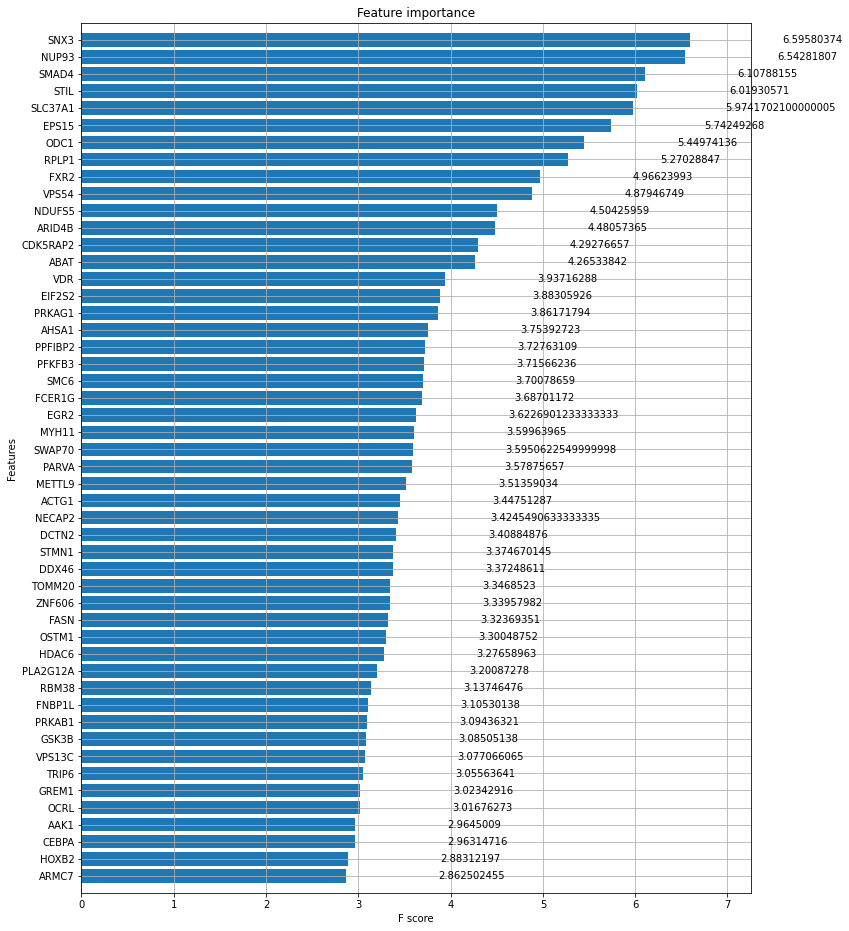

In [17]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(12, 16))
plot_importance(clf_v1, max_num_features=50, height=0.8, ax=ax, importance_type='gain')
plt.show()

#### Generate List 1 genes using XGB to rank the genes by gain

In [18]:
feature_importance_g= clf_v1.get_booster().get_score(importance_type='gain')
ranked_features_g = {k: v for k, v in sorted(feature_importance_g.items(), key=lambda x: x[1], reverse=True)}
ranked_genes_g = [gene for gene in ranked_features_g]
top_500_v1 = ranked_genes_g[:500]
top_500_v1[:10]

['SNX3',
 'NUP93',
 'SMAD4',
 'STIL',
 'SLC37A1',
 'EPS15',
 'ODC1',
 'RPLP1',
 'FXR2',
 'VPS54']

In [19]:
pop_genes = X.columns.to_list()
# pop_genes = [x for x in X_17705.columns.to_list() if x not in feat_diff_exp]
len(pop_genes)

4382

In [92]:
with open("datasets/pln_goa_comp/top_500_genes_goa.txt", "w") as fp:
    print_array(top_500_v1, fp)

In [20]:
from convert_symbol_to_entrez import read_symbol2geneid

sym2geneid = read_symbol2geneid("datasets/Homo_sapiens.gene_info")

  126,696 READ: datasets/Homo_sapiens.gene_info


#### Use GOATools to get list 1

In [21]:
go_lst_1_df = run_gene_enrich(top_500_v1, pop_genes, "datasets/pln_goa_comp/list_1", sym2geneid)

datasets/go-basic.obo: fmt(1.2) rel(2021-02-01) 47,291 GO Terms; optional_attrs(relationship)
HMS:0:00:04.515247 335,863 annotations, 20,672 genes, 18,441 GOs, 1 taxids READ: gene2go 
Study: 327 vs. Population 4382


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 97%  4,250 of  4,382 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 99%  4,328 of  4,382 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 98%  4,296 of  4,382 population items found in association

Run BP Gene Ontology Analysis: current study set of 327 IDs ... 99%    323 of    327 study items found in association
100%    327 of    327 study items found in population(4382)
Calcu

In [22]:
print(go_lst_1_df.shape)
display(go_lst_1_df.head(5))
go_lst_1 = list(go_lst_1_df.sort_values(by="p_uncorrected")["# GO"])

(348, 14)


,# GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_bonferroni,p_sidak,p_holm,p_fdr_bh,study_items
0,GO:0043462,BP,e,regulation of ATPase activity,11/327,36/4382,0.000037,5,11,0.433527,0.422597,0.433527,0.433527,"1266, 3300, 3434, 4057, 4171, 5216, 6742, 7157..."
1,GO:0070102,BP,e,interleukin-6-mediated signaling pathway,5/327,9/4382,0.000220,7,5,1.000000,1.000000,1.000000,0.855333,"1050, 3572, 4089, 5781, 6774"
2,GO:0032780,BP,e,negative regulation of ATPase activity,5/327,9/4382,0.000220,6,5,1.000000,1.000000,1.000000,0.855333,"1266, 3434, 4057, 4171, 7157"
3,GO:0051346,BP,e,negative regulation of hydrolase activity,22/327,136/4382,0.000404,5,22,1.000000,1.000000,1.000000,1.000000,"334, 341, 358, 1266, 1471, 1718, 2537, 2810, 2..."
4,GO:0051170,BP,e,import into nucleus,12/327,59/4382,0.001110,7,12,1.000000,1.000000,1.000000,1.000000,"754, 5514, 5571, 6636, 6774, 6850, 7157, 8720,..."


In [23]:
patient_ppt = pd.read_table("datasets/patients_exp/property_vector_beforekpca_p=1,T=2_notnormalized_2021-05-05.csv", index_col="patient_ID")
print(patient_ppt.shape)

gene_ppt = pd.read_table("datasets/genes_exp/property_vector_beforekpca_p=1,T=2_notnormalized_2021-05-09.csv", index_col="node_ID")
print(gene_ppt.shape)

gene_ints = pd.read_table("datasets/genes_exp/intensional_similarity_2021-05-12.tsv", index_col="node_ID")
gene_ints.columns = gene_ints.index.to_list()
display(gene_ints)

(649, 22359)
(4382, 16495)


,MRPS27,SNRPC,USP16,ACACA,HK2,LRPAP1,HTR4,DNAJB12,POLR1C,ACTR2,...,LYPLA2,RXRB,MAP7,MICAL2,IL13RA1,TBC1D2B,DNAJB2,ATP8B1,DPP3,OLFML2B
node_ID,,,,,,,,,,,,,,,,,,,,,
MRPS27,1.000000,0.096110,0.207385,0.071272,0.056459,0.038204,0.047082,0.061656,0.130198,0.074700,...,0.029211,0.188968,0.046925,0.196218,0.044734,0.011389,0.098698,0.076127,0.031683,0.000371
SNRPC,0.096110,1.000000,0.075851,0.070631,0.040243,0.006358,0.028622,0.073290,0.117338,0.018020,...,0.025133,0.120436,0.023177,0.052696,0.010679,0.003407,0.021577,0.049837,0.089951,0.000442
USP16,0.207385,0.075851,1.000000,0.089713,0.061117,0.031171,0.027282,0.154340,0.063119,0.104935,...,0.091842,0.231809,0.030368,0.224948,0.017516,0.013726,0.168507,0.082687,0.113088,0.000237
ACACA,0.071272,0.070631,0.089713,1.000000,0.173525,0.030166,0.024046,0.063412,0.086815,0.100980,...,0.063453,0.119657,0.036339,0.079299,0.012071,0.034911,0.059877,0.145481,0.040694,0.000152
HK2,0.056459,0.040243,0.061117,0.173525,1.000000,0.067193,0.025800,0.069226,0.061884,0.105882,...,0.049725,0.062365,0.052498,0.063785,0.017084,0.040397,0.090609,0.130208,0.024555,0.000138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TBC1D2B,0.011389,0.003407,0.013726,0.034911,0.040397,0.050526,0.014565,0.003376,0.014167,0.044224,...,0.008090,0.015625,0.054115,0.010923,0.017732,1.000000,0.082811,0.073839,0.013016,0.000619
DNAJB2,0.098698,0.021577,0.168507,0.059877,0.090609,0.073508,0.025359,0.275624,0.054056,0.054590,...,0.064179,0.084566,0.025420,0.059206,0.029717,0.082811,1.000000,0.052639,0.043454,0.000213
ATP8B1,0.076127,0.049837,0.082687,0.145481,0.130208,0.084226,0.072532,0.038807,0.040771,0.116127,...,0.052194,0.103667,0.061634,0.121272,0.018059,0.073839,0.052639,1.000000,0.029494,0.000178


In [24]:
import re
pat_go = re.compile("GO:\d+")
patient_go_cols = [x for x in patient_ppt.columns.to_list() if pat_go.match(x)]
print(len(patient_go_cols))
gene_cols = [x for x in gene_ppt.columns.to_list() if pat_go.match(x)]
print(len(gene_cols))
go_cols = list(set(gene_cols) & set(patient_go_cols))
print(len(go_cols))
gene_go_cols = list(set(patient_go_cols) - set(gene_cols))
print(len(gene_go_cols))
print(gene_go_cols[:10])

15767
16494
15765
2
['GO:0048308', 'GO:0000001']


In [25]:
gene_go_cols[:10]

['GO:0048308', 'GO:0000001']

In [26]:
gene_ppt

,GO:0071279,GO:0120031,GO:0000176,GO:0052740,GO:0015860,GO:0005402,GO:0072718,GO:0048019,GO:0002889,GO:1901098,...,GO:0036506,GO:0048496,GO:0000803,GO:0061518,GO:0097338,GO:0060287,GO:0019374,GO:0051011,GO:0055129,GO:0072207
node_ID,,,,,,,,,,,,,,,,,,,,,
MRPS27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SNRPC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
USP16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACACA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HK2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TBC1D2B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DNAJB2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATP8B1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
pat_not_gene = re.compile("(GO:\d+|R\-HSA\-\d+|PA\d+$|^\$)")
patient_gene_cols = [x for x in patient_ppt.columns.to_list() if not pat_not_gene.match(x)]
print(len(patient_gene_cols))
gene_ppt_cols = gene_ppt.index.to_list()
print(len(gene_ppt_cols))
genes_intsn_cols = gene_ints.index.to_list()
print(len(genes_intsn_cols))
gene_cols = list(set(gene_ppt_cols) & set(patient_gene_cols) & set(genes_intsn_cols))
print(list(set(gene_ppt_cols) - set(patient_gene_cols)))
print(len(gene_cols))

4381
4382
4382
['MCM2']
4381


In [28]:
patient_ppt_f = patient_ppt[go_cols + gene_cols]
print(patient_ppt_f.shape)
genes_df = pd.concat([gene_ppt, gene_ints], axis=1)
genes_df = genes_df[go_cols + gene_cols]
print(genes_df.shape)

(649, 20146)
(4382, 20146)


#### Merge the patient and gene property vectors

In [29]:
merged_df = pd.concat([patient_ppt_f, genes_df], axis=0)
display(merged_df)
# merged_df.to_csv("datasets/patient_gene_go_ppty.tsv", sep="\t", index=True, index_label="node_ID")


,GO:0034663,GO:0097212,GO:0040033,GO:0038098,GO:1901616,GO:0061732,GO:0019674,GO:0043318,GO:0097345,GO:0071733,...,PSMB8,LRRC8B,CD2AP,ODC1,SMN1,PRDX1,LMNA,LARS2,PCGF1,ARMCX1
249600,0.000000,0.000000,0.000000,0.000000,0.000332,0.000068,0.000000,0.000000,0.000000,0.000043,...,0.130280,0.204972,0.161396,0.000000,0.000000,0.000000,0.000000,0.060232,0.000000,0.000000
441891,0.000000,0.000280,0.000000,0.000337,0.000900,0.000049,0.000801,0.000346,0.000224,0.000291,...,0.082496,0.000000,0.000000,0.000000,0.029350,0.000000,0.060599,0.000000,0.147197,0.241483
249532,0.000368,0.000745,0.000430,0.000201,0.000013,0.000692,0.001575,0.000038,0.000358,0.000098,...,0.050244,0.039822,0.000000,0.030987,0.109105,0.242995,0.248406,0.281080,0.000000,0.000000
22476,0.000027,0.000748,0.000000,0.000024,0.000380,0.000000,0.000000,0.000012,0.000000,0.000052,...,0.098451,0.109610,0.235100,0.193964,0.097056,0.111063,0.050471,0.164644,0.000000,0.000000
441736,0.000000,0.000000,0.000367,0.000253,0.000000,0.000000,0.000000,0.000000,0.000000,0.000159,...,0.000000,0.000000,0.086397,0.000000,0.149673,0.000000,0.067840,0.055238,0.000000,0.000017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TBC1D2B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.028774,0.033832,0.021470,0.018775,0.054991,0.013446,0.087429,0.004493,0.011550,0.004484
DNAJB2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.154617,0.020093,0.116581,0.077917,0.035057,0.095392,0.110174,0.040701,0.077160,0.027570
ATP8B1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.074202,0.083142,0.071196,0.060724,0.080872,0.043831,0.082857,0.109357,0.181042,0.023594
DPP3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.066872,0.017025,0.069872,0.060130,0.054245,0.054536,0.007619,0.078871,0.079181,0.023193


#### Embed the patients and the genes together and apply PCA

In [30]:
K_df = pd.read_table("datasets/embedding_kpca_tanimoto_2021-05-17.tsv", index_col="node_ID")
display(K_df)

,0,1,2,3,4,5,6,7,8,9,...,5021,5022,5023,5024,5025,5026,5027,5028,5029,5030
node_ID,,,,,,,,,,,,,,,,,,,,,
249600,1.000000,0.217171,0.090450,0.252757,0.216793,0.219600,0.182354,0.212057,0.197057,0.246892,...,0.106801,0.136892,0.142760,0.149254,0.112863,0.113004,0.105950,0.113186,0.177486,0.009895
441891,0.217171,1.000000,0.270042,0.234971,0.242951,0.294520,0.201192,0.217125,0.200014,0.254719,...,0.144579,0.195203,0.166117,0.202382,0.120263,0.141037,0.157026,0.160966,0.222210,0.014752
249532,0.090450,0.270042,1.000000,0.224785,0.200974,0.259122,0.237149,0.235498,0.211849,0.068734,...,0.145673,0.266389,0.154042,0.242976,0.102441,0.149479,0.191619,0.209638,0.198192,0.009284
22476,0.252757,0.234971,0.224785,1.000000,0.197652,0.333024,0.234446,0.297533,0.243480,0.274820,...,0.132001,0.195488,0.158429,0.197056,0.125593,0.148551,0.153932,0.158819,0.213068,0.009976
441736,0.216793,0.242951,0.200974,0.197652,1.000000,0.224143,0.142735,0.231689,0.253051,0.240975,...,0.116623,0.152767,0.156878,0.171694,0.118447,0.124264,0.118259,0.129561,0.205931,0.021555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TBC1D2B,0.113004,0.141037,0.149479,0.148551,0.124264,0.145238,0.111627,0.142244,0.136666,0.129482,...,0.072219,0.087214,0.187548,0.100967,0.082605,1.000000,0.146319,0.156157,0.109609,0.005094
DNAJB2,0.105950,0.157026,0.191619,0.153932,0.118259,0.157817,0.147079,0.150751,0.135883,0.125815,...,0.146676,0.207394,0.100732,0.192078,0.083962,0.146319,1.000000,0.158255,0.149983,0.003509
ATP8B1,0.113186,0.160966,0.209638,0.158819,0.129561,0.162098,0.160053,0.153481,0.137772,0.137635,...,0.125723,0.256470,0.142866,0.262755,0.076678,0.156157,0.158255,1.000000,0.135160,0.003437


In [31]:
kpca = KernelPCA(kernel="precomputed")
emb = kpca.fit_transform(K_df)
emb_df = pd.DataFrame(emb, index=K_df.index)
display(emb_df)

,0,1,2,3,4,5,6,7,8,9,...,4987,4988,4989,4990,4991,4992,4993,4994,4995,4996
node_ID,,,,,,,,,,,,,,,,,,,,,
249600,-0.137424,0.022681,0.194425,-0.130972,-0.010358,-0.095173,0.048949,-0.126727,-0.093033,-0.120578,...,3.287037e-07,-1.941913e-06,8.793326e-07,1.758754e-05,1.149705e-06,-1.980039e-07,4.505392e-08,-1.083339e-08,-1.553508e-08,3.239659e-09
441891,-0.100593,0.045819,0.105036,-0.048670,0.054169,-0.070836,0.074574,-0.131400,-0.052302,0.032992,...,-1.515514e-07,1.964246e-07,7.211868e-08,1.205617e-06,-1.566967e-07,4.856679e-09,-8.669581e-08,-2.562319e-08,-2.677719e-09,-1.358978e-10
249532,0.029585,0.019979,-0.014637,0.056114,0.078908,-0.043566,0.076437,-0.102445,-0.015022,0.137095,...,-4.713960e-07,8.976612e-07,-8.290454e-07,1.325617e-06,3.064370e-07,2.825575e-07,-1.830440e-07,1.158376e-07,1.902997e-09,1.131463e-09
22476,-0.094803,0.043590,0.127907,-0.059931,0.062563,-0.085176,0.073185,-0.140996,-0.054065,-0.017933,...,6.829855e-07,-2.186721e-07,-5.430500e-07,-6.593666e-07,-1.517965e-07,-7.778957e-08,8.134360e-08,9.562519e-09,-4.896088e-09,4.602696e-10
441736,-0.136512,0.019682,0.192837,-0.104036,0.021317,-0.065019,0.037261,-0.108564,-0.063065,-0.038578,...,-3.509565e-07,-7.340001e-07,1.437766e-07,5.323560e-07,2.178348e-07,-8.323414e-08,-7.876891e-08,-1.415291e-08,3.603175e-09,-9.731216e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TBC1D2B,-0.191762,-0.218038,0.073230,0.314472,0.105449,-0.066560,0.064129,0.044762,-0.087941,-0.075731,...,-6.370059e-06,6.163127e-06,2.600897e-06,9.166486e-07,-6.657788e-07,-4.741130e-08,-2.639331e-07,8.304168e-08,5.829709e-09,-3.764160e-10
DNAJB2,0.082432,-0.071192,-0.148276,-0.056380,0.105033,-0.072073,-0.074920,-0.019372,-0.022404,0.002697,...,-9.532811e-07,-1.853000e-07,1.068897e-06,-4.410976e-08,-1.737097e-07,-2.097073e-08,-1.960759e-08,9.536593e-09,-7.106272e-10,1.113941e-09
ATP8B1,0.119517,-0.072379,-0.023195,0.070943,-0.000790,0.103557,0.084854,0.043501,-0.027855,-0.011950,...,-3.201198e-06,4.852345e-07,-7.896457e-07,-2.229389e-07,-2.394037e-07,5.424509e-08,8.725599e-08,5.928322e-09,-9.383868e-09,-1.465723e-09


#### Rank the components with XGBoost and generate v with the relevance values

This returns a vector V whose i'th element shows the score/rank of the the i'th PC

In [33]:
patient_emb = emb_df.head(649)
display(patient_emb.head(2))
gene_emb = emb_df.tail(4382)
display(gene_emb.head(2))

,0,1,2,3,4,5,6,7,8,9,...,4987,4988,4989,4990,4991,4992,4993,4994,4995,4996
node_ID,,,,,,,,,,,,,,,,,,,,,
249600,-0.137424,0.022681,0.194425,-0.130972,-0.010358,-0.095173,0.048949,-0.126727,-0.093033,-0.120578,...,3.287037e-07,-1.941913e-06,8.793326e-07,0.000018,1.149705e-06,-1.980039e-07,4.505392e-08,-1.083339e-08,-1.553508e-08,3.239659e-09
441891,-0.100593,0.045819,0.105036,-0.048670,0.054169,-0.070836,0.074574,-0.131400,-0.052302,0.032992,...,-1.515514e-07,1.964246e-07,7.211868e-08,0.000001,-1.566967e-07,4.856679e-09,-8.669581e-08,-2.562319e-08,-2.677719e-09,-1.358978e-10


,0,1,2,3,4,5,6,7,8,9,...,4987,4988,4989,4990,4991,4992,4993,4994,4995,4996
node_ID,,,,,,,,,,,,,,,,,,,,,
MRPS27,0.197509,0.162704,0.037476,0.082523,-0.008984,-0.067462,-0.026887,0.035656,-0.115092,0.312293,...,-0.000008,4.283099e-07,-0.000006,-8.357871e-08,5.622904e-07,-2.647382e-07,-2.899354e-07,-7.129774e-08,-4.154433e-09,-4.297128e-09
SNRPC,-0.032300,0.288223,-0.054389,0.089366,-0.243443,-0.187447,-0.064682,0.097252,0.131911,0.003265,...,-0.000003,3.149626e-06,-0.000001,-1.004828e-07,3.025465e-07,-1.396453e-08,1.381760e-07,4.891908e-08,-7.134034e-09,4.163783e-09


In [34]:
patient_emb.index = patient_emb.index.map(str)
y.index = y.index.map(str)
X_emb = patient_emb.join(y)

In [35]:
# params_v2, clf_v2, cv_scores_v2, test_scores_v2 = evaluate_ge(X_emb)
clf_v2, cv_scores_v2, test_scores_v2 = evaluate_ge(X_emb, params={'subsample': 0.6, 'scale_pos_weight': 0.5, 'n_estimators': 120, 'min_child_weight': 1, 'max_depth': 6, 'max_delta_step': 3, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 0.8})

[21:30:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV Score: 
balanced_accuracy      0.548999
recall_0               0.125000
precision_0            0.697619
recall_1               0.972999
precision_1            0.755935
auc                    0.675827
specificity            0.125000
average_precision_0    0.246911
dtype: float64

Test Score:
balanced_accuracy      0.532271
recall_0               0.078431
precision_0            0.666667
recall_1               0.986111
precision_1            0.751323
auc                    0.662446
specificity            0.078431
average_precision_0    0.249686
dtype: float64



In [36]:
feature_importance_g_2= clf_v2.get_booster().get_score(importance_type='gain')
feat_scores_v2 = {}
for k, v in feature_importance_g_2.items():
    feat_scores_v2[int(k.strip())] = v

for c in patient_emb.columns:
    if c not in feat_scores_v2:
        feat_scores_v2[c] = 0

v_emb = [v for k, v in sorted(feat_scores_v2.items(), key=lambda x: x[0])]
v_emb = np.array(v_emb)
v_emb.shape

(4997,)

In [37]:
v_emb[:10]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       6.28031969, 0.        , 0.        , 0.        , 0.        ])

In [38]:
def find_projections(emb, v):
    res = {}
    idxs = emb.index
    for i in idxs:
        a = emb.loc[i].values
        res[str(i)] = np.abs(np.dot(a, v) / np.linalg.norm(v))

    return res

#### Project each embedded gene vector a onto v

Here the gene vectors are generated using PLN where every gene is described by GO terms

$$ \textbf{p} = \frac{\textbf{a}  . \textbf{v}}{\textbf{v} . \textbf{v}} $$

In [39]:
gene_proj = find_projections(gene_emb, v_emb)

#### Rank the genes using the norm of the projection

In [40]:
genes_pln_rank = {k: v for k, v in sorted(gene_proj.items(), key=lambda x: x[1], reverse=True)}
genes_pln_lst = [k.strip() for k in genes_pln_rank]
genes_lst_rank = {k: r for r, k in enumerate(genes_pln_lst)}

In [41]:
top_500_genes_pln = genes_pln_lst[:500]
top_500_genes_pln[:15]

['DIP2C',
 'SLC25A14',
 'ADAM8',
 'DNAJC15',
 'EPB41L3',
 'PKIG',
 'ENSA',
 'LAMC2',
 'SH2D4A',
 'CBX1',
 'RSU1',
 'LYPLA1',
 'OGFR',
 'TCEAL1',
 'PLXNC1']

In [93]:
with open("datasets/pln_goa_comp/top_500_genes_pln.txt", "w") as fp:
    print_array(top_500_genes_pln, fp)

In [43]:
go_lst_2_df = run_gene_enrich(top_500_genes_pln, pop_genes, "datasets/pln_goa_comp/list_2", sym2geneid)


datasets/go-basic.obo: fmt(1.2) rel(2021-02-01) 47,291 GO Terms; optional_attrs(relationship)
HMS:0:00:05.319670 335,863 annotations, 20,672 genes, 18,441 GOs, 1 taxids READ: gene2go 
Study: 500 vs. Population 4382


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 97%  4,250 of  4,382 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 99%  4,328 of  4,382 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 98%  4,296 of  4,382 population items found in association

Run BP Gene Ontology Analysis: current study set of 500 IDs ... 94%    471 of    500 study items found in association
100%    500 of    500 study items found in population(4382)
Calcu

In [44]:
print(go_lst_2_df.shape)
display(go_lst_2_df.head())

(589, 14)


,# GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_bonferroni,p_sidak,p_holm,p_fdr_bh,study_items
0,GO:1902600,BP,e,proton transmembrane transport,22/500,39/4382,9.329131e-12,8,22,1.087217e-07,1.059807e-07,1.087217e-07,1.087217e-07,"476, 523, 537, 1337, 1340, 1345, 1346, 1347, 1..."
1,GO:0098662,BP,e,inorganic cation transmembrane transport,33/500,108/4382,4.612506e-08,7,33,5.375414e-04,5.239891e-04,5.373569e-04,8.993082e-05,"476, 493, 523, 537, 1317, 1337, 1340, 1345, 13..."
2,GO:0070126,BP,e,mitochondrial translational termination,19/500,47/4382,2.853584e-07,8,19,3.325566e-03,3.241724e-03,3.321286e-03,2.078479e-04,"740, 6150, 10573, 10884, 26284, 26589, 29088, ..."
3,GO:0006123,BP,e,"mitochondrial electron transport, cytochrome c...",9/500,12/4382,4.915466e-07,8,9,5.728484e-03,5.584060e-03,5.720128e-03,3.014992e-04,"1337, 1340, 1345, 1349, 1350, 1355, 4697, 9167..."
4,GO:0019646,BP,e,aerobic electron transport chain,9/500,12/4382,4.915466e-07,7,9,5.728484e-03,5.584060e-03,5.720128e-03,3.014992e-04,"1337, 1340, 1345, 1349, 1350, 1355, 4697, 9167..."


In [45]:
go_lst_2 = list(go_lst_2_df.sort_values(by="p_uncorrected")["# GO"])

In [46]:
overlap, diff_1, diff_2 = find_overlap_go(go_lst_1, go_lst_2)

Num overlap: 19
Num found in list 1, not in list 2:329
Num found in list 2, not in list 1: 570


In [203]:
overlap_df = go_lst_2_df[go_lst_2_df["# GO"].isin(overlap)]
overlap_df.to_csv("datasets/pln_goa_comp/goa_pln_overlap.csv", index=False)
display(overlap_df)

,# GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_bonferroni,p_sidak,p_holm,p_fdr_bh,study_items
126,GO:0022900,BP,e,electron transport chain,17/500,89/4382,2.776690e-02,4,17,1.000000,1.000000,1.000000,1.000000,"1337, 1340, 1345, 1346, 1347, 1349, 1350, 1355..."
127,GO:0051248,BP,e,negative regulation of protein metabolic process,57/500,381/4382,2.796729e-02,6,57,1.000000,1.000000,1.000000,1.000000,"468, 493, 634, 819, 868, 871, 1028, 1031, 1293..."
134,GO:0042059,BP,e,negative regulation of epidermal growth factor...,6/500,22/4382,3.239353e-02,8,6,1.000000,1.000000,1.000000,1.000000,"374, 868, 1845, 9052, 10252, 23636"
202,GO:1901185,BP,e,negative regulation of ERBB signaling pathway,6/500,24/4382,4.808288e-02,7,6,1.000000,1.000000,1.000000,1.000000,"374, 868, 1845, 9052, 10252, 23636"
211,GO:0009056,BP,p,catabolic process,40/500,718/4382,8.674842e-09,2,40,0.000101,0.000099,0.000101,0.000031,"161, 216, 634, 1211, 1891, 2108, 2548, 3303, 4..."
212,GO:0044248,BP,p,cellular catabolic process,33/500,634/4382,1.057062e-08,3,33,0.000123,0.000120,0.000123,0.000031,"161, 1211, 1891, 2108, 2548, 3303, 4552, 5261,..."
216,GO:1901575,BP,p,organic substance catabolic process,34/500,621/4382,8.419210e-08,3,34,0.000981,0.000956,0.000981,0.000106,"161, 216, 634, 1211, 1891, 2108, 2548, 3303, 4..."
228,GO:0009057,BP,p,macromolecule catabolic process,21/500,416/4382,4.600502e-06,4,21,0.053614,0.052263,0.053481,0.001787,"161, 634, 1211, 2548, 3303, 5261, 5976, 6832, ..."
229,GO:0044265,BP,p,cellular macromolecule catabolic process,17/500,363/4382,5.914580e-06,5,17,0.068929,0.067191,0.068751,0.002224,"161, 1211, 3303, 5976, 6832, 6992, 7126, 7347,..."
254,GO:0023056,BP,p,positive regulation of signaling,42/500,590/4382,2.796637e-04,4,42,1.000000,1.000000,1.000000,0.047929,"101, 374, 537, 1028, 1847, 1848, 2280, 3265, 3..."


In [202]:
diff_1_df = go_lst_1_df[go_lst_1_df["# GO"].isin(diff_1)]
diff_1_df.to_csv("datasets/pln_goa_comp/goa_pln_diff_1.csv", index=False)
display(diff_1_df)

,# GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_bonferroni,p_sidak,p_holm,p_fdr_bh,study_items
0,GO:0006658,BP,e,phosphatidylserine metabolic process,4/339,7/4382,0.001021,7,4,1.0,1.0,1.0,1.0,"9791, 10955, 81579, 114884"
1,GO:0070986,BP,e,left/right axis specification,3/339,4/4382,0.001731,4,3,1.0,1.0,1.0,1.0,"4853, 10370, 54806"
2,GO:0002064,BP,e,epithelial cell development,10/339,45/4382,0.001851,4,10,1.0,1.0,1.0,1.0,"2316, 2810, 3572, 4615, 4853, 5170, 8826, 9414..."
3,GO:0030512,BP,e,negative regulation of transforming growth fac...,8/339,31/4382,0.001916,8,8,1.0,1.0,1.0,1.0,"3309, 4052, 5170, 5494, 7049, 7311, 26036, 58533"
4,GO:0051965,BP,e,positive regulation of synapse assembly,4/339,8/4382,0.001918,7,4,1.0,1.0,1.0,1.0,"4915, 7336, 9231, 64084"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,GO:0019899,MF,e,enzyme binding,74/339,776/4382,0.045209,3,74,1.0,1.0,1.0,1.0,"18, 150, 161, 162, 391, 468, 801, 811, 847, 89..."
256,GO:0004879,MF,e,nuclear receptor activity,4/339,18/4382,0.045245,4,4,1.0,1.0,1.0,1.0,"196, 7026, 7421, 9975"
257,GO:0098531,MF,e,ligand-activated transcription factor activity,4/339,18/4382,0.045245,3,4,1.0,1.0,1.0,1.0,"196, 7026, 7421, 9975"
258,GO:0019213,MF,e,deacetylase activity,3/339,11/4382,0.047485,3,3,1.0,1.0,1.0,1.0,"3340, 10013, 23408"


In [199]:
len(diff_2)

573

In [201]:
diff_2_df = go_lst_2_df[go_lst_2_df["# GO"].isin(diff_2)]
diff_2_df.to_csv("datasets/pln_goa_comp/goa_pln_diff_2.csv", index=False)
display(diff_2_df)

,# GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_bonferroni,p_sidak,p_holm,p_fdr_bh,study_items
0,GO:1902600,BP,e,proton transmembrane transport,22/500,39/4382,9.329131e-12,8,22,1.087217e-07,1.059807e-07,1.087217e-07,1.087217e-07,"476, 523, 537, 1337, 1340, 1345, 1346, 1347, 1..."
1,GO:0098662,BP,e,inorganic cation transmembrane transport,33/500,108/4382,4.612506e-08,7,33,5.375414e-04,5.239891e-04,5.373569e-04,8.993082e-05,"476, 493, 523, 537, 1317, 1337, 1340, 1345, 13..."
2,GO:0070126,BP,e,mitochondrial translational termination,19/500,47/4382,2.853584e-07,8,19,3.325566e-03,3.241724e-03,3.321286e-03,2.078479e-04,"740, 6150, 10573, 10884, 26284, 26589, 29088, ..."
3,GO:0019646,BP,e,aerobic electron transport chain,9/500,12/4382,4.915466e-07,7,9,5.728484e-03,5.584060e-03,5.720128e-03,3.014992e-04,"1337, 1340, 1345, 1349, 1350, 1355, 4697, 9167..."
4,GO:0006123,BP,e,"mitochondrial electron transport, cytochrome c...",9/500,12/4382,4.915466e-07,8,9,5.728484e-03,5.584060e-03,5.720128e-03,3.014992e-04,"1337, 1340, 1345, 1349, 1350, 1355, 4697, 9167..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,GO:0008233,MF,p,peptidase activity,10/500,163/4382,3.186138e-02,3,10,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,"101, 7347, 9929, 9986, 10010, 10730, 10988, 23..."
585,GO:0016773,MF,p,"phosphotransferase activity, alcohol group as ...",16/500,230/4382,3.229906e-02,4,16,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,"1944, 1945, 3055, 5209, 5261, 5293, 5580, 6352..."
586,GO:0106311,MF,p,protein threonine kinase activity,4/500,87/4382,4.055433e-02,7,4,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,"7443, 28996, 29110, 51347"
587,GO:0048029,MF,p,monosaccharide binding,0/500,30/4382,4.238240e-02,3,0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,NaN


In [96]:
gsea_tamox_0_df = pd.read_csv("datasets/gseaGOreactome_tamox4k_0.csv")
gsea_tamox_1_df = pd.read_csv("datasets/gseaGOreactome_tamox4k_1.csv")

In [97]:
gsea_tamox_pln_0_df = pd.merge(go_lst_2_df, gsea_tamox_0_df, left_on="# GO", right_on="EXACT_SOURCE")
gsea_tamox_pln_1_df = pd.merge(go_lst_2_df, gsea_tamox_1_df, left_on="# GO", right_on="EXACT_SOURCE")
print(gsea_tamox_pln_0_df.shape)
print(gsea_tamox_pln_1_df.shape)

(218, 25)
(147, 25)


In [98]:
gsea_tamox_pln_0_df["NES_Rank"] = gsea_tamox_pln_0_df["NES"].abs().rank(ascending=False, method="first")
gsea_tamox_pln_1_df["NES_Rank"] = gsea_tamox_pln_1_df["NES"].rank(ascending=False, method="first")
gsea_tamox_pln_0_df["PLN_Rank"] = gsea_tamox_pln_0_df["p_uncorrected"].abs().rank(method="first")
gsea_tamox_pln_1_df["PLN_Rank"] = gsea_tamox_pln_1_df["p_uncorrected"].rank(method="first")

In [100]:
gsea_tamox_goa_0_df = pd.merge(go_lst_1_df, gsea_tamox_0_df, left_on="# GO", right_on="EXACT_SOURCE")
gsea_tamox_goa_1_df = pd.merge(go_lst_1_df, gsea_tamox_1_df, left_on="# GO", right_on="EXACT_SOURCE")
print(gsea_tamox_goa_0_df.shape)
print(gsea_tamox_goa_1_df.shape)

(96, 25)
(162, 25)


In [101]:

gsea_tamox_goa_0_df["NES_Rank"] = gsea_tamox_goa_0_df["NES"].abs().rank(ascending=False, method="first")
gsea_tamox_goa_0_df["GOA_Rank"] = gsea_tamox_goa_0_df["p_uncorrected"].abs().rank(method="first")
gsea_tamox_goa_1_df["NES_Rank"] = gsea_tamox_goa_1_df["NES"].abs().rank(ascending=False, method="first")
gsea_tamox_goa_1_df["GOA_Rank"] = gsea_tamox_goa_1_df["p_uncorrected"].abs().rank(method="first")

In [56]:
gsea_tamox_goa_1_df.head(2)

,# GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_bonferroni,...,NES,NOM p-val,FDR q-val,FWER p-val,RANK AT MAX,LEADING EDGE,EXACT_SOURCE,coverage,NES_Rank,GOA_Rank
0,GO:0070102,BP,e,interleukin-6-mediated signaling pathway,5/327,9/4382,0.000220,7,5,1.0,...,0.709485,0.054852,0.947262,1.0,269,"tags=67%, list=6%, signal=71%",GO:0070102,0.310345,22.0,1.0
1,GO:0051346,BP,e,negative regulation of hydrolase activity,22/327,136/4382,0.000404,5,22,1.0,...,0.381289,0.102510,0.964464,1.0,858,"tags=33%, list=18%, signal=39%",GO:0051346,0.303178,93.0,2.0


#### Rank Correlation b/n PLN List and GSEA 1

In [102]:
from scipy.stats import spearmanr, kendalltau
pln_rank_1_lst = gsea_tamox_pln_1_df["PLN_Rank"].to_list()
nes_rank_1_lst = gsea_tamox_pln_1_df["NES_Rank"].to_list()

spear_corr = spearmanr(pln_rank_1_lst, nes_rank_1_lst)
kdl_tau = kendalltau(pln_rank_1_lst, nes_rank_1_lst)
print(spear_corr)
print(kdl_tau)

SpearmanrResult(correlation=-0.17155399738569993, pvalue=0.03774123506897862)
KendalltauResult(correlation=-0.11042773273693039, pvalue=0.047183432956230995)


#### Rank Correlation b/n PLN List and GSEA 0

In [103]:
from scipy.stats import spearmanr
pln_rank_0_lst = gsea_tamox_pln_0_df["PLN_Rank"].to_list()
nes_rank_0_lst = gsea_tamox_pln_0_df["NES_Rank"].to_list()

spear_corr_0 = spearmanr(pln_rank_0_lst, nes_rank_0_lst)
kdl_tau_0 = kendalltau(pln_rank_0_lst, nes_rank_0_lst)
print(spear_corr_0)
print(kdl_tau_0)

SpearmanrResult(correlation=-0.12603515786754727, pvalue=0.0632254718200785)
KendalltauResult(correlation=-0.08045491058216718, pvalue=0.07711851122244258)


#### Rank Correlation b/n GOA List and GSEA 1


In [59]:
from scipy.stats import spearmanr, kendalltau
goa_rank_1_lst = gsea_tamox_goa_1_df["GOA_Rank"].to_list()
goa_nes_rank_1_lst = gsea_tamox_goa_1_df["NES_Rank"].to_list()

spear_corr = spearmanr(goa_rank_1_lst, goa_nes_rank_1_lst)
kdl_tau = kendalltau(goa_rank_1_lst, goa_nes_rank_1_lst)
print(spear_corr)
print(kdl_tau)

SpearmanrResult(correlation=-0.18059842413003255, pvalue=0.021460309447081865)
KendalltauResult(correlation=-0.12123303427651255, pvalue=0.022032247433203266)


#### Rank Correlation b/n GOA List and GSEA 0

In [60]:
from scipy.stats import spearmanr, kendalltau
goa_rank_0_lst = gsea_tamox_goa_0_df["GOA_Rank"].to_list()
goa_nes_rank_0_lst = gsea_tamox_goa_0_df["NES_Rank"].to_list()

spear_corr = spearmanr(goa_rank_0_lst, goa_nes_rank_0_lst)
kdl_tau = kendalltau(goa_rank_0_lst, goa_nes_rank_0_lst)
print(spear_corr)
print(kdl_tau)

SpearmanrResult(correlation=-0.04883342376559956, pvalue=0.6365826153121312)
KendalltauResult(correlation=-0.020614035087719293, pvalue=0.766060437360897)


In [104]:
gsea_tamox_pln_0_df.to_csv("datasets/pln_goa_comp/gsea_tamox_pln_0.csv")
gsea_tamox_pln_1_df.to_csv("datasets/pln_goa_comp/gsea_tamox_pln_1.csv")

In [105]:
gsea_tamox_goa_0_df.to_csv("datasets/pln_goa_comp/gsea_tamox_goa_0.csv")
gsea_tamox_goa_1_df.to_csv("datasets/pln_goa_comp/gsea_tamox_goa_1.csv")

### Check the ranking and GOs when predicting for relapse

In [61]:
# params_v3, clf_v3, cv_scores_v3, test_scores_v3 = evaluate_ge(X_emb, rand_scoring=average_precision_0)
clf_v3, cv_scores_v3, test_scores_v3 = evaluate_ge(X_emb, params={'subsample': 0.6, 'scale_pos_weight': 0.1, 'n_estimators': 80, 'min_child_weight': 3, 'max_depth': 5, 'max_delta_step': 3, 'learning_rate': 0.07, 'gamma': 2, 'colsample_bytree': 1.0})

[21:57:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV Score: 
balanced_accuracy      0.536330
recall_0               0.950000
precision_0            0.280783
recall_1               0.122659
precision_1            0.827899
auc                    0.627731
specificity            0.950000
average_precision_0    0.263429
dtype: float64

Test Score:
balanced_accuracy      0.494485
recall_0               0.843137
precision_0            0.259036
recall_1               0.145833
precision_1            0.724138
auc                    0.584423
specificity            0.843137
average_precision_0    0.263785
dtype: float64



In [62]:
feature_importance_g_3= clf_v3.get_booster().get_score(importance_type='gain')
feat_scores_v3 = {}
for k, v in feature_importance_g_3.items():
    feat_scores_v3[int(k.strip())] = v

for c in patient_emb.columns:
    if c not in feat_scores_v3:
        feat_scores_v3[c] = 0

v_emb_2 = [v for k, v in sorted(feat_scores_v3.items(), key=lambda x: x[0])]
v_emb_2 = np.array(v_emb_2)
v_emb_2.shape

(4997,)

In [63]:
gene_proj_v2 = find_projections(gene_emb, v_emb_2)

#### Rank the genes using the norm of the projection

In [64]:
genes_pln_rank_v2 = {k: v for k, v in sorted(gene_proj_v2.items(), key=lambda x: x[1], reverse=True)}
genes_pln_lst_v2 = [k.strip() for k in genes_pln_rank_v2]
genes_lst_rank_v2 = {k: r for r, k in enumerate(genes_pln_lst_v2)}

In [65]:
top_500_genes_pln_v2 = genes_pln_lst_v2[:500]
top_500_genes_pln_v2[:10]

['BTG3',
 'DENR',
 'MORF4L2',
 'PRR11',
 'NCBP1',
 'TCEAL1',
 'MRPL18',
 'LUC7L',
 'SLC25A36',
 'CLNS1A']

In [66]:
go_lst_3_df = run_gene_enrich(top_500_genes_pln_v2, pop_genes, "datasets/pln_goa_comp/list_3", sym2geneid)
display(go_lst_3_df)
go_lst_3 = list(go_lst_3_df.sort_values(by="p_uncorrected")["# GO"])

datasets/go-basic.obo: fmt(1.2) rel(2021-02-01) 47,291 GO Terms; optional_attrs(relationship)
HMS:0:00:04.950157 335,863 annotations, 20,672 genes, 18,441 GOs, 1 taxids READ: gene2go 
Study: 500 vs. Population 4382


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 97%  4,250 of  4,382 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 99%  4,328 of  4,382 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 98%  4,296 of  4,382 population items found in association

Run BP Gene Ontology Analysis: current study set of 500 IDs ... 91%    455 of    500 study items found in association
100%    500 of    500 study items found in population(4382)
Calcu

,# GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_bonferroni,p_sidak,p_holm,p_fdr_bh,study_items
0,GO:0070126,BP,e,mitochondrial translational termination,39/500,47/4382,5.824079e-30,8,39,6.787381e-26,6.616261e-26,6.787381e-26,6.787381e-26,"740, 6150, 6183, 7818, 9801, 10240, 10573, 108..."
1,GO:0070125,BP,e,mitochondrial translational elongation,39/500,49/4382,1.222926e-28,7,39,1.425198e-24,1.389267e-24,1.425076e-24,7.125990e-25,"740, 6150, 6183, 7818, 9801, 10240, 10573, 108..."
2,GO:0006415,BP,e,translational termination,39/500,51/4382,1.898081e-27,7,39,2.212024e-23,2.156256e-23,2.211645e-23,7.373414e-24,"740, 6150, 6183, 7818, 9801, 10240, 10573, 108..."
3,GO:0006414,BP,e,translational elongation,40/500,58/4382,2.968350e-25,6,40,3.459315e-21,3.372101e-21,3.458425e-21,8.648288e-22,"740, 1984, 6150, 6183, 7818, 9801, 10240, 1057..."
4,GO:0043624,BP,e,cellular protein complex disassembly,39/500,68/4382,2.551599e-20,6,39,2.973633e-16,2.898663e-16,2.972613e-16,5.947266e-17,"740, 6150, 6183, 7818, 9801, 10240, 10573, 108..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,GO:0050839,MF,p,cell adhesion molecule binding,18/500,250/4382,3.101583e-02,3,18,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,"90, 975, 1289, 3303, 3337, 3693, 5214, 5493, 6..."
800,GO:0005509,MF,p,calcium ion binding,11/500,171/4382,3.641287e-02,5,11,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,"663, 794, 3708, 4017, 6279, 6280, 6286, 8404, ..."
801,GO:0019899,MF,p,enzyme binding,72/500,776/4382,3.997098e-02,3,72,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,"90, 142, 143, 834, 1031, 1075, 1540, 1660, 197..."
802,GO:0106311,MF,p,protein threonine kinase activity,4/500,87/4382,4.055433e-02,7,4,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,"4751, 5591, 29110, 65018"


In [67]:
gsea_tamox_pln_0_df_v2 = pd.merge(go_lst_3_df, gsea_tamox_0_df, left_on="# GO", right_on="EXACT_SOURCE")
gsea_tamox_pln_1_df_v2 = pd.merge(go_lst_3_df, gsea_tamox_1_df, left_on="# GO", right_on="EXACT_SOURCE")
print(gsea_tamox_pln_0_df_v2.shape)
print(gsea_tamox_pln_1_df_v2.shape)

(281, 25)
(236, 25)


In [68]:
gsea_tamox_pln_0_df_v2["NES_Rank"] = gsea_tamox_pln_0_df_v2["NES"].abs().rank(ascending=False, method="first")
gsea_tamox_pln_0_df_v2["PLN_Rank"] = gsea_tamox_pln_0_df_v2["p_uncorrected"].abs().rank(method="first")
gsea_tamox_pln_1_df_v2["NES_Rank"] = gsea_tamox_pln_1_df_v2["NES"].abs().rank(ascending=False, method="first")
gsea_tamox_pln_1_df_v2["PLN_Rank"] = gsea_tamox_pln_1_df_v2["p_uncorrected"].abs().rank(method="first")

In [69]:
from scipy.stats import spearmanr, kendalltau
pln_rank_1_lst_v2 = gsea_tamox_pln_1_df_v2["PLN_Rank"].to_list()
nes_rank_1_lst_v2 = gsea_tamox_pln_1_df_v2["NES_Rank"].to_list()

spear_corr = spearmanr(pln_rank_1_lst_v2, nes_rank_1_lst_v2)
kdl_tau = kendalltau(pln_rank_1_lst_v2, nes_rank_1_lst_v2)
print(spear_corr)
print(kdl_tau)

SpearmanrResult(correlation=-0.2892804484472787, pvalue=6.2611732580624344e-06)
KendalltauResult(correlation=-0.18730616660656327, pvalue=1.8324059956238683e-05)


In [198]:
gsea_tamox_pln_1_df_v2.to_csv("datasets/pln_goa_comp/gsea_tamox_pln_0_v2.csv")
gsea_tamox_pln_1_df_v2.to_csv("datasets/pln_goa_comp/gsea_tamox_pln_1_v2.csv")